# A/B Testing Theory Notes  

**OUTLINE**:  
________________
- **Preparation**
  - Import Packages
  - Define Functions
  - Some statistical knowledge
- **What is A/B Testing?**
- **Choosing and Characterizing**
  - Experiment
  - Set Our Business Objective
  - Refining the Customer Funnel
  - Metrix Choice
    - About Data
    - How To Validate Metrics
    - Make Sure The Definitions Are Clear
    - Filtering and Segmenting
    - Build Intuition
    - Characterize
  - Hypothesis
- **Designing an Experiment**
  - Unit of Diversion
  - Target Population
  - Sizing
  - Duration
  - Learning Effect
- **Analyzing Results**  
  - Sanity Check
    - Choosing Invariants
  - Handle Evaluation with Single or Multiple Metrics
    - Single Metric
    - Multiple Metrics
- **Conclusion**
_______________

## Preparation  

### Import Packages

In [114]:
import numpy as np
import scipy.stats as stats
import math
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

### Define Funtions

In [115]:
## Strategy: 
## (1) For a bunch of Ns, compute the z_star by achieving desired alpha, then
## (2) compute what beta would be for that N using the acquired z_star. 
## (3) Pick the smallest N at which beta crosses the desired value

# Inputs: 
#         The desired alpha for a two-tailed test
# Returns: 
#         The z-critical value
def get_z_star(alpha):
    return -norm.ppf(alpha / 2)
# Inputs:
#        z-star: The z-critical value
#        s: The standard error of the metric at N=1
#        d_min: The practical significance level
#        N: The sample size of each group of the experiment
# Returns: 
#        The beta value of the two-tailed test
def get_beta(z_star, s, d_min, N): 
    SE = s / math.sqrt(N)
    return norm.cdf(z_star * SE, loc=d_min, scale=SE)

# Inputs:
#        s: The standard error of the metric with N=1 in each group
#        d_min: The practical significance level
#        Ns: The sample sizes to try
#        alpha: The desired alpha level of the test
#        beta: The desired beta level of the test
# Returns: 
#        The smallest N out of the given Ns that will achieve the desired
#        beta. There should be at least N samples in each group of the experiment.
#        If none of the given Ns will work, returns -1. N is the number of samples in each group.
def required_size(s, d_min, Ns=range(1, 20001), alpha=0.05, beta=0.2):
    for N in Ns:
        if get_beta(get_z_star(alpha), s, d_min, N) <= beta:
            return N
    return -1

In [116]:
# draw a plot to show decision boundary
def decision(lowerCI, upperCI, x):
    y = 2.5
    min_x = min(lowerCI, upperCI, x)  # Minimum x-value
    max_x = max(lowerCI, upperCI, x)
    extend = (max_x - min_x) * 0.5  # Extend the x-axis by 50% of the range
    dot_positions = [lowerCI, upperCI, x]
    fig, ax = plt.subplots(figsize=(3, 0.5))
    ax.axis('off')
    ax.hlines(y, xmin=min_x-extend, xmax=max_x+extend, linestyle='-')
    for position in dot_positions:
        if position == lowerCI or position == upperCI:
            ax.vlines(position, ymin=y-0.05, ymax=y+0.05, color='black', linewidth=1)
        else:
            ax.scatter(position, y, color='red', s=100, zorder=3)
    plt.show()

In [130]:
# print table in markdown format
def mkdtable(df):
    markdown_table = df.to_markdown(index=False)
    # Print the Markdown code
    print(markdown_table)

### Some statistical knowledge

#### **What is $\alpha$ and $\beta$**
Type I error: $\alpha=P(\{\text{reject null} | \text{null true} \})$  
Type II error: $\beta=P(\{\text{fail to reject null} | \text{null false} \})$  
Power: $1-\beta$  

<img src="image/20.png" width="700"> 



## What is A/B testing?  

A/B testing is a general methodology used online when you want to test out a new product or a feature.  
  
What you're doing is you're going to take two separate users and you show one set (a control set), your existing product or feature and then another set (your experiment), the new version and what you're going to do is we're going to say how do these users respond differently and which is to determine which version of this feature is better.  
  
AB testing is really useful for helping you climb to the peak of your current mountain. But if you want to figure out whether you want to be on this mountain or another mountain A/B testing isn't so useful.  
  
Some categories companies practiced:   
- New Feature Additions [Amazong Personalized recommendations]()  
- ranking changes [Linkin ranking changes]()  
- Some changes that you are not sure a user would notice. [Amazon page load time]()  [Google web search time]()  
  
But There are some things you cannot do with AB testing:  
- A/B testing isn't a useful testing out new experiences.  
- Some problems need long time to test, like the rental.  

The key thing to remember is that the goal of doing A/B tests is to determine whether or not this new product or this new feature is something that users will like.  The goal in A/B tests is to design an experiment that is going to be robust and give you repeatable results. so you can actually make a good decision about whether or not to actually launch that product or feature.



## Choosing and Characterizing Metrics

### Experiment

> change the **start now** button from orange to pink

### Set our Business objective  

> - helping students get jobs  
> - financial sustainability

### Refining the customer funnel

> <img src="image/1.png" width="300">   
> 
> Here are related actions in each step:   
> 
> <img src="image/2.png" width="600">



By refining the funnel and actions, we are able to draw the metrics in each step and then select the appropriate ones.  

> In each stage, we collect the following data:  
> - count: the number of users who reach that point  
>   
> - rate or probabilities: $\frac{\text{number of users of current point}}{\text{number of users of previous point}}$  


### Metrics Choices 
- Invariant Metrics:  
  - Invariant metrics are performance metrics that are expected to <span style="background-color: #edd2c4">remain consistent</span> between the control group (the group that receives the current or existing experience) and the experimental group (the group that receives the new or modified experience). These metrics are used to ensure that the groups are comparable before drawing conclusions about the impact of the experimental change. Invariant metrics are also known as "pre-treatment" or "sanity-check" metrics.  
  - The purpose of invariant metrics is to validate that the <span style="background-color: #edd2c4">randomization</span> process and the assignment of users to the control and experimental groups are working correctly. If there are significant differences in these metrics between the two groups before the experiment, it can indicate issues with randomization or that the groups are not comparable, which would undermine the validity of the test results.  
- Evaluation Metrics:  
  - Evaluation metrics are the <span style="background-color: #edd2c4">key performance indicators (KPIs)</span> or measurements used to assess the impact and effectiveness of changes made in an experiment. These metrics are used to determine whether the variant (the group receiving the change) outperforms the control (the group with the existing experience) in a statistically significant and meaningful way.  
  - Evaluation metrics serve as the primary means of quantifying and comparing the outcomes of the two groups to make data-driven decisions about whether to implement the change or not. The choice of evaluation metrics depends on the specific goals and objectives of the A/B test. Different experiments may have different evaluation metrics that align with their intended outcomes.  

> Some metrics to be considered:  
> 1. Click-Through-Rate (CTR) on "start now" button
> 2. Click-through-probability (CTP) on "start now" button
> 3. Probability of progressing from course list to course page
> 4. Probability of progressing from course page to enrolling
> 5. Probability that enrolled student pays for coaching

#### **About data:**   
   
Sometimes there are some difficult metrics, which means we do not have access to data or it takes a long time. Here are some techniques to get data:  
- External Data ([Additional Techniques for Brainstorming and Validating Metrics](extension://bfdogplmndidlpjfhoijckpakkdjkkil/pdf/viewer.html?file=https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fgae-supplemental-media%2Fadditional-techniquespdf%2Fadditional_techniques.pdf))
  - Companies collect fairly granular data (like market share)
  - Companies run surveys of users
  - Academic research  
- Own Data
  - Using existing data(Retrospective/observational analysis):  
     - look at the metrics you are interested in or just measurements you take from your site, change in response to changes you made in the past. That is good to get a baseline, and it can also help you develop theories. These studies show you correlations, not causation.
  - Gather new data: (<span style="color: green">**+**</span> stands for positive part, <span style="color: red">**-**</span> stands for negative part)
     - User experience research (UER):  
       <span style="color: green">**+**</span> good for brainstorming  
       <span style="color: green">**+**</span> can use special equipment  
       <span style="color: red">**-**</span>  want to validate results          
     - Focus Group:  
       <span style="color: green">**+**</span> get feedback on hypotheticals  
       <span style="color: red">**-**</span>  run the risk of group think  
     - Surveys:  
       <span style="color: green">**+**</span> useful for metrics you cannot directly measure  
       <span style="color: red">**-**</span>  cannot directly compare to other results.    
<img src="image/3.png" width="300">

#### **How to validate metrics**:  
1. Running experiment:   
   measure if the metric is actually going to move as we make changes. (sensitivity and robustness)
2. Talk to your colleagues  

#### **Make sure the definitions are clear**:  
  
Step1: Fully define what data we are going to look at to actually compute the metric.  
Step2: Given those event, how do I summarize my metric? (build intuition)  
  
Example:  
<img src="image/4.png" width="800">



#### **Filtering and Segmenting**:  
  
Increase the <span style="background-color: #edd2c4">sensitivity and robust</span> about the experiment.  
The goal is <span style="background-color: #edd2c4">de-bias</span> the data  
Good for evaluating definition and build intuition  
  
Why do we need to filter and segment the data:   
- External reasons: malicious mess up the metrics  
- Internal reasons: what happens if your change only impact a subset of your traffic. So, just filter the affected traffic, do not dilute the data, then you can actually increase the power and sensitivity of your experiment.  
  
Example:  
<img src="image/5.png" width="800">   
<img src="image/6.png" width="800">    




#### **Build Intuition**  
  
Summarize all individual events into a single summary metric (numbers $\rightarrow$ median, mean, mode or etc.)   
  
1. <span style="background-color: #90ccc3">Sensitivity and Robustness</span>
- To compute or control sensitivity:
   - Running experiment or using the experiment we have:  
       see if the metrics we were interested in is actually respond to the changes in a simple experiment. We should tell if they are actually moving in a way that intuitively makes sense. We can also use what were called A vs. A experiment, that is, the experiment where you do not change anything, just compare people who saw the same thing to each other.
   - Retrospective analysis
       Measuring sensitivity and robustness:  
       <img src="image/7.png" width="800">  
       <img src="image/8.png" width="800">    

2. <span style="background-color: #90ccc3">Distribution</span>  
- Doing the retrospective analysis and compute the histogram  
- Some common distribution:  
   - [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution):  
	Application: measure the average stay time on the results page before traveling to a result. 
   - [Zip-fan or Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution):  
	the probability of a more extreme value, $z$, decreases like $\frac{1}{z}$ (or $\frac{1}{z^{e}}$).  
   This distribution also comes up in other rare events such as the frequency of words in a text (the most common word is really really common compared to the next word on the list). 
   These types of heavy-tailed distributions are common in internet data.
	
	you may have data that is a composition of different distributions. This forms what is called a mixture distribution that can be hard to detect or characterize well.  
   
- Four categorize to memorize:  
   - Sums and counts  
   - mean, median, 25%,50%,75% percentile  
   - probability and rate  
   - ratios  


#### **Characterize**:  

Variability is used to sizing the experiment and analyze the confidence interval.  
  
<span style="color: grey">Sizing will be introduced later, we firstly learn how to calculate a confidence interval.</span>  
  
In order to calculate a confidence interval, we need:  
- Variance  
- Distribution  
   - example: binomial distribution  
      The PMF of getting exactly k successes in n independent Bernoulli trials is:  
        
      $f(k,n,p)=Pr(k,n,p)=Pr(X=K)= \binom{n}{k} \cdot p^k \cdot (1-p)^{n-k}$  
        
      $ \text{standard error(SE)} = \sqrt{\frac{p \cdot (1 - p)}{n}}$  
        
      As N get larger, Binomial distribution is close to a Normal distribution.  
        
      $ \text{m (mean)} = z * SE$, where $z=\frac{x-\mu}{\sigma}$

Calculating Variability:  
  
<img src="image/9.png" width="600"> 




Non-parametric answers: you have a way to analyze the data without making the assumption of the distribution: sign test.  
  
Sometimes you do not want to launch unless you meet some threshold (your practical significance level). Firstly look at the summary statistic metric:  
- <span style="background-color: #90ccc3">If it is nice and normal, using normal distributed CI and variant.</span>  
    <img src="image/11.png" width="800">   
- <span style="background-color: #90ccc3">If it is funnier or you really need robust, then calculate the non-parametric CI (directly estimate CI).</span>  
   - STEP 1: take all your differences and put them in order.  
      <img src="image/10-1.png" width="500">   
   - STEP 2:  if you want a 95% confidence interval, select a box that includes only 95% of the values. (Eg. We have 20 data point, which means dropping the highest and the lowest gives us a 90% confidence level. Then, empirical standard deviation=0.059*1.65=0.097)
      <img src="image/10-2.png" width="500"> 
   - **Reasons to use the empirical method:**  

      When you compute the variance of the metric, you are making an assumption about the underlying distribution of the data. Even for some simple metrics, the analytical estimate of the variance ended up being an underestimate. Using <span style="color: red">A versus A experiments</span> again.  
  
      - <span style="background-color: #90ccc3">A/A experiment:</span>   
        a control A and another control A. If you see a lot of variability in a metric in an A versus A test, it is probably too sensitive to be useful in. We can kind of pin down the variability with these A/A test. In order to get a good sense, sometimes we need to run thousand times. There is a diminishing return as you run more A versus A tests. The key rule of thumb to keep in mind is that the standard deviation is going to be proportional to the square root of the number of sample. Or, we can run one big A/A experiment.   
  
      - <span style="background-color: #90ccc3">Bootstrap:</span>  
        <img src="image/12.png" width="500">  

        The idea in bootstrapping is that you Increase the <span style="background-color: #edd2c4">run one experiment</span>. <span style="color: #e0e0e0">And even though in our spreadsheet we only showed one number from each group, for each experiment, the click-through probability, those numbers were actually calculated from a lot of individual data points, about a bunch of individual page views and clicks.</span> Then you Increase the <span style="background-color: #edd2c4">take a random sample</span> of those data points Increase the <span style="background-color: #edd2c4">from each side</span> of the experiment, and Increase the <span style="background-color: #edd2c4">calculate</span> the CTP based on that random sample as if it were a full experimental group. Then you Increase the <span style="background-color: #edd2c4">record the difference</span> in click through probabilities and use that as a simulated experiment. Then you Increase the <span style="background-color: #edd2c4">repeat</span> this process over and over, Increase the <span style="background-color: #edd2c4">recording</span> the results. And you can use the results as if you had run multiple experiments, even though you really only ran one big experiment.  
      
      The advantage of running lots of different <span style="background-color: #edd2c4">A/A tests</span> is because if your experiment system is itself complicated, it is actually a very good test of your system <span style="color: #e0e0e0">(eg. Is your randomization function truly random? Bias? Population effects?).</span> In reality, what we have is a whole gradation of different methods. If you are starting out and you are running your first experiment using a relatively simple metric, do the analytical estimate of variance.  
        
      If you are starting to push towards more complicated metrics or you are running more and more features through, at that point, you might want to consider at least doing the <span style="background-color: #edd2c4">bootstrap</span>. Now if your bootstrap estimate is agreeing with your analytical estimate, you can probably move on and you do not have to worry about it. If it isn't agreeing with your analytical estimate, at that piont you may want to consider runniung a lot of A/A tests and really digging into understanding what's going on.



> - Total number of courses complete (take too much time)  
>   
> - CTR $= \frac{\text{Number of clicks}}{\text{number of page views}}$  
>     
> - CTP $= \frac{\text{unique visitors who click}}{\text{unique visitors to page}}$  
> 
> In this case, we choose CTP.  

### Hypothesis
> Change color will increase the CTP of the button

## Designing an experiment  

### Choose Subject (unit of diversion)  

 <img src="image/13.png" width="1000">  


**How to choose between different diversions?**  

- Consistency  
- Ethical Consideration
- Variability

### Target Population  

If you thin you can identify what population will be affected by your experiment, you might want to target your experiment to that traffic. How does this affect the variability of the traffic?  
Changing the unit of diverging can change the empirical estimate of variability. Filtring your traffic can change it too. 

> EXAMPLE:  
> - You want to control the change that will only affect users in New Zealand to see whether it increases CTP.  
> 
> After running the experiment, there are($X$ stands for people who clicked):  
> 
> - $N_{cont}=6021, X_{cont}=302$  
> - $N_{exp}=5979, X_{exp}=374$   
> 
> Based on this, we can calculate:  

In [118]:
# New Zealand data
N_nz_cont=6021
N_nz_exp=5979
X_nz_cont=302
X_nz_exp=374
p_nz_estimate_cont= X_nz_cont/N_nz_cont
print(f'New Zealand Control p_estimate(baseline probability)={p_nz_estimate_cont*100:.2f}%')
p_nz_estimate_exp= X_nz_exp/N_nz_exp
print(f'New Zealand Experiment p_estimate={p_nz_estimate_exp*100:.2f}%')
p_nz_estimate_pool=(X_nz_cont+X_nz_exp)/(N_nz_cont+N_nz_exp)
print(f'New Zealand Pool p_estimate={p_nz_estimate_pool*100:.2f}%')
SE_nz_pool=np.sqrt(p_nz_estimate_pool*(1-p_nz_estimate_pool)*(1/N_nz_cont+1/N_nz_exp))
print(f'New Zealand Standard Erro={SE_nz_pool:.4f}')

New Zealand Control p_estimate(baseline probability)=5.02%
New Zealand Experiment p_estimate=6.26%
New Zealand Pool p_estimate=5.63%
New Zealand Standard Erro=0.0042


> We also have other countries' data:  
> - $N_{cont}=50000, X_{cont}=2500$  
> - $N_{exp}=50000, X_{exp}=2500$   

In [119]:
# Other Countries' data
N_other_cont=50000
N_other_exp=50000
X_other_cont=2500
X_other_exp=2500

In [120]:
# Global data:
N_g_cont=N_nz_cont+N_other_cont
N_g_exp=N_nz_exp+N_other_exp
X_g_cont=X_nz_cont+X_other_cont
X_g_exp=X_nz_exp+X_other_exp
p_g_estimate_cont= X_g_cont/N_g_cont
print(f'Global Control p_estimate(baseline probability)={p_g_estimate_cont*100:.2f}%')
p_g_estimate_exp= X_g_exp/N_g_exp
print(f'Global Experiment p_estimate={p_g_estimate_exp*100:.2f}%')
p_g_estimate_pool=(X_g_cont+X_g_exp)/(N_g_cont+N_g_exp)
print(f'Global Pool p_estimate={p_g_estimate_pool*100:.2f}%')
SE_g_pool=np.sqrt(p_g_estimate_pool*(1-p_g_estimate_pool)*(1/N_g_cont+1/N_g_exp))
print(f'Global Pool Standard Error={SE_g_pool:.4f}')


Global Control p_estimate(baseline probability)=5.00%
Global Experiment p_estimate=5.13%
Global Pool p_estimate=5.07%
Global Pool Standard Error=0.0013


||New Zealand|Global|
|----|----|----|
|$\hat p_{cont}$|5.02%|5.00%|
|$\hat p_{exp}$|6.26%|5.13%|
|$\hat p_{pool}$|5.63%|5.07%|
|$ SE_{pool}$|0.0042|0.0013|

> We can see that the variability of Global is much lower than New Zealand. Because there are more data globally.  
In practice, the data will actually be a mix of different populations almost every time. When you filter, you're going to get a smaller but more uniform population, which means that for the same number of data points, the variability of the filtered data is likely to be lower.

In [121]:
# Global significance test
diff_estimate = p_g_estimate_exp-p_g_estimate_cont
print(f'Difference in p_estimate={diff_estimate:.4f}')
m=SE_g_pool*1.96
print(f'Margin of Error={m:.4f}')
print(f'Confidence Interval={diff_estimate-m:.4f} to {diff_estimate+m:.4f}')

Difference in p_estimate=0.0013
Margin of Error=0.0026
Confidence Interval=-0.0012 to 0.0039


> 0 is within the confidence interval, or to say, the difference is neither larger than the margin of error nor samller than the negative margin of error, we cannot reject the null hypothesis, so it is not significant.

In [122]:
# New Zealand significance test
diff_estimate = p_nz_estimate_exp-p_nz_estimate_cont
print(f'Difference in p_estimate={diff_estimate:.4f}')
m=SE_nz_pool*1.96
print(f'Margin of Error={m:.4f}')
print(f'Confidence Interval={diff_estimate-m:.4f} to {diff_estimate+m:.4f}')


Difference in p_estimate=0.0124
Margin of Error=0.0083
Confidence Interval=0.0041 to 0.0206


> 0 is not within the confidence interval, or to say, the difference is larger than the margin of error, we can reject the null hypothesis, so it is significant.  

#### **Population VS. Cohort**  
  
In the population, you have a whole group of users. But within that population you can define what's called a cohort. And typically, this means people who enter the experiment at the same time.  
  
Cohort usually means that you define an entering class and you only look at users who entered your experiment on both sides around the same time, and you go forward from there.  
  
Cohorts are harder to analyze, and they're going to take more data because you'll lose users. So typically, you only want to use them when you're looking for user stability.  
  
When to use a cohort instead of a population:  
- looking for learning effects  
- examing user retention  
- want to increase user activity   
- anything requiring user to be established  




### Sizing  

We need a fair amount of user data to make the experienment work.  

**How variability affects sizing?**

> Example:   
> - Audacity includes promotions for coaching next to videos. Experiment: change wording of message.  
> 
> Metric: 
> - $CTR=\frac{\# clicks}{\# pageviews}$  
> 
> Unit of diversion: 
> - pageview or cookie  
>
> Here are same data:
> - empirical estimate with 5000 pageviews  
> - By sampling pageview, we get SD=0.00515  
> - By sampling cookie, we get SD=0.0119  
> - To calculate size, we assume SE ~ $\frac{1}{\sqrt{N}}$, that is:  
> <img src="image/14.png" width="350">   
> - In this case, we set practical significance $d_{min}=0.02$

In [123]:
s = math.sqrt(0.1 * 0.9 * 2)
required_size(s, d_min=0.02)

3532

In [124]:
SD_pageview=0.00515
SD_cookie=0.0119
d_min=0.02
# cookie-based
print(required_size(s=SD_pageview*math.sqrt(5000), d_min=d_min))
# browser-based
print(required_size(s=SD_cookie*math.sqrt(5000), d_min=d_min))


2603
13894


In order to  translate our ideal size into a set of practical decisions. We need to know:  
- what's the duration of the experiment that I want to run?  
   <span style="color: grey">let's say we're and we need **1 million** cookies in our experiment and our control combined. Now, if you only get a **100,000** cookies visiting your site on any given day. That means that if you want to run **50%** of your traffic through the experiment and 50% through the control, you need to run your experiment control for **10 days**. Now, another choice is to run your experiment at **25%** each, say, it's because you want to run another test, then you'd have to run your experiment for **20 days** as opposed to 10. And that's how, the duration of your experiment, is related to the proportion of traffic that you're sending through your experiment.</span>  
   <span style="color: grey"></span>
- when do I want to run the experiment?
- Is it going to overlap something that's important?
- what fraction of your traffic you're going to send through the experiment?

### Learning Effect

when a user first sees a change, they're going to tend to react in one of these two ways. But over time they're going to probably plateau to a very different behavior. Now, the key issue with trying to measure a learning effect is time. It takes time for you just to actually adapt to a change and often times you don't have the luxury of taking that much time to make a decision.   
  
- choosing the unit of diversion correctly
- dosage
- risk and duration


## Analzing results

We are going to see what you can or cannot conclude fro the data that you've captured.  
Remember that running A/B testing is an iterative process.

### Sanity Checks

Population sizing metrics:   
- based on your unit of diversion.What you're really checking there is that your experiment population and your control populations are actually comparable.  
  
Actual invariants:  
- those metrics that shouldn't change when you run your experiment. And what you want to do is you want to test that they didn't change.  

####  **Choosing Invariants:**  
  
<img src="image/15.png" width="700">   
<img src="image/16.png" width="700">   


#### **checking invariants**

> - Running experiments for 2 weeks
> - Unit of diversion: Cookies  
>   
> Here is the data we collect:  

In [131]:
# print table in markdown format

data_week1 = {'Day': ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"],
              '# cookies control': [5077,5495,5294,5446,5126,3382,2891],
              '# cookies experiment': [4877,4729,5063,5035,5010,3193,3226]}
df_w1 = pd.DataFrame(data_week1)
mkdtable(df=df_w1)

data_week2 = {'Day': ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"],
                '# cookies control': [5029,5166,4902,4923,4816,3411,3496],
                '# cookies experiment': [5092,5048,4985,4805,4741,2939,3075]}
df_w2 = pd.DataFrame(data_week2)
mkdtable(df=df_w2)


| Day   |   # cookies control |   # cookies experiment |
|:------|--------------------:|-----------------------:|
| Mon   |                5077 |                   4877 |
| Tues  |                5495 |                   4729 |
| Wed   |                5294 |                   5063 |
| Thurs |                5446 |                   5035 |
| Fri   |                5126 |                   5010 |
| Sat   |                3382 |                   3193 |
| Sun   |                2891 |                   3226 |
| Day   |   # cookies control |   # cookies experiment |
|:------|--------------------:|-----------------------:|
| Mon   |                5029 |                   5092 |
| Tues  |                5166 |                   5048 |
| Wed   |                4902 |                   4985 |
| Thurs |                4923 |                   4805 |
| Fri   |                4816 |                   4741 |
| Sat   |                3411 |                   2939 |
| Sun   |                3496 |

- <span style="background-color: #90ccc3">See the total numbers of each group to check the overall difference.</span>

In [132]:
N_cont=df_w1['# cookies control'].sum()+df_w2['# cookies control'].sum()
N_exp=df_w1['# cookies experiment'].sum()+df_w2['# cookies experiment'].sum()
print(f'Total control number={N_cont}')
print(f'Total experiment number={N_exp}')
N_total=N_cont+N_exp
print(f'Total number={N_total}')

Total control number=64454
Total experiment number=61818
Total number=126272


&emsp;&emsp; We can see that there are more data in the control group, now the question is that:  
- <span style="background-color: #90ccc3">How would you figure out whether this difference is within expectations?</span>  
    
  This is similar to the event: flipping a fair coin, I want to know if it's surprising that the coin came up heads 64,454 times. The total sample size here is about 120,000, which is definitely enough to assume a normal distribution.  
    
  - 1. Compute standard deviation of binomial with probability 0.5 of success.  
  - 2. Multiply by [z-score](https://www.z-table.com/) to get margin of error.  
  - 3. Compute confidence interval around 0.5.  
  - 4. Check whether observed fraction is within interval.


Standard Deviation=0.0014
Margin of Error=0.0028
Confidence Interval=0.4972 to 0.5028
Observed fraction=0.5104


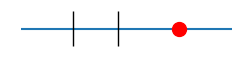

In [133]:
# Compute standard deviation of binomial with probability 0.5 of success.  
p=0.5
SD=np.sqrt(p*(1-p)/N_total)
print(f'Standard Deviation={SD:.4f}')

# Multiply by z-score to get margin of error.  
m=SD*1.96
print(f'Margin of Error={m:.4f}')

# Compute confidence interval around 0.5.  
lc=0.5-m
uc=0.5+m
print(f'Confidence Interval={lc:.4f} to {uc:.4f}')

# Check whether observed fraction is within interval.
p_hat=N_cont/N_total
print(f'Observed fraction={p_hat:.4f}')

# draw the decision line
decision(lowerCI=lc, upperCI=uc, x=p_hat)

&emsp;&emsp;To get a better idea of what could be going wrong, it's a good idea to look at the day by day data again. One good thing to check is whether any particular day stands out as causing the problem or whether it seems to be an overall pattern.

In [134]:
df_w1['p_hat'] = df_w1['# cookies control'] / (df_w1['# cookies control'] + df_w1['# cookies experiment'])
df_w2['p_hat'] = df_w2['# cookies control'] / (df_w2['# cookies control'] + df_w2['# cookies experiment'])

> **Data for Week 1**
> |   Day |   # cookies control |   # cookies experiment | $\hat p$ |
> |------:|--------------------:|-----------------------:|---------:|
> |   Mon |                5077 |                   4877 | 0.510172 |
> |  Tues |                5495 |                   4729 | <span style="background-color: yellow;">0.537846</span> |
> |   Wed |                5294 |                   5063 | 0.511739 |
> | Thurs |                5446 |                   5035 | 0.519748 |
> |   Fri |                5126 |                   5010 | 0.505426 |
> |   Sat |                3382 |                   3193 | 0.514824 |
> |   Sun |                2891 |                   3226 | <span style="background-color: yellow;">0.472065</span> |

> **Data for Week 2**
> | Day   |   # cookies control |   # cookies experiment | $\hat p$ |
> |:------|--------------------:|-----------------------:|---------:|
> | Mon   |                5029 |                   5092 | 0.496888 |
> | Tues  |                5166 |                   5048 | 0.505776 |
> | Wed   |                4902 |                   4985 | 0.495803 |
> | Thurs |                4923 |                   4805 | 0.506065 |
> | Fri   |                4816 |                   4741 | 0.503924 |
> | Sat   |                3411 |                   2939 | <span style="background-color: yellow;">0.537165</span> |
> | Sun   |                3496 |                   3075 | <span style="background-color: yellow;">0.532035</span> |

&emsp;&emsp; We can see there are some abnormal probabilities, then, we can：  
&emsp;&emsp;&emsp;1. Talk to the engineers.  
&emsp;&emsp;&emsp;2. Try slicing to see if one particular slice is weired.  
&emsp;&emsp;&emsp;3. check age of cookies: does one group have more new cookies?  

- <span style="background-color: #90ccc3">What happens if one of your sanity checks fails?</span>   
&emsp;&emsp;  
  If your sanity checks fail, do not pass go. <span style="background-color: #edd2c4">Do not proceed</span>, go straight to analyzing why your sanity checks fail. You really have to <span style="background-color: #edd2c4">debug</span> and understand what's going on before you can actually analyze your experiment. Because, if you try and move on past that, your conclusions are almost certainly wrong.  
&emsp;&emsp;  
- <span style="background-color: #90ccc3">How do you figure out what went wrong?</span>   
&emsp;&emsp;  
   - First, something might have gone wrong <span style="background-color: #edd2c4">technically</span>, and you want to work with your engineers to understand, is there something going on with the experiment infrastructure? Did I get the experiment set up correctly? Is something wrong with experiment diversion? You really want to debug the experiment setup with the engineers. 
   - Second, you can try and do a <span style="background-color: #edd2c4">retrospective analysis</span>. Try and recreate experiment diversion from the data capture, and understand that this is something endemic to what you're trying to do that may be causing the situation. 
   - Third, we can try and use <span style="background-color: #edd2c4">pre and post periods</span> we talked about earlier in lesson four. If you're in a pre-period, then you can say, did I see the same changes in those invariance in my pre-period? If I saw them in the pre-period and the experiment, that points to a problem with the experiment infrastructure, the set up, something along those lines. On the other hand, if you see the change only in your experiment but not in the pre-period, that points to something with the experiment itself, maybe the data capture or something along those lines.   
&emsp;&emsp;  
- <span style="background-color: #90ccc3">What are the most common reasons you've seen for data not matching up like this?</span>   
&emsp;&emsp;  
  1. <span style="background-color: #edd2c4">data capture</span>. especially when you want to capture a new experience that the user is undergoing. And so maybe you just didn't capture it correctly. Maybe the change triggers very rarely, and you capture it correctly in the experiment, but you don't capture quickly in the control, and so you're not comparing like with like. That's probably the most common.  
  2. <span style="background-color: #edd2c4">the experiment's set up</span>. So, for example, what happens if you have a filter to English only? Maybe you set up for the experiment, but not the control, and now your publishes aren't comparable. More rarely, it could be your infrastructure, or the ex, you know, the experiment system, something along those lines. Maybe there's something going on to really sort of reset cookies, and that's what's sort of screwing things up. You just have to go through and test all of them.  
&emsp;&emsp;  
- <span style="background-color: #90ccc3">Is it ever just a real difference?</span>   
&emsp;&emsp;  
  It could be, but it's probably not a good thing if it is.  
  For example, there's something in the infrastructure that's going on to cause the cookies to churn. You probably don't want that, your user's probably not having a good experience, and it's not good for the experiment itself. Right? Now the key thing to remember is that all of these comparisons, they're approximations. So you're not going to get an exactly the same number. It's just going to be approximately the same.  
  The other thing that I get asked a lot is, well, maybe my users are learning over time, maybe it's, you know, users are adapting to the change. Now, the key thing there is that, if there really is a learning effect, then you're going to see not very much change in the beginning, and it's going to be increasing over time. So if you're seeing a big change right from the beginning, it's probably not a learning effect. Then if all the sanity checks do pass, we can analyze the experiment.


### Handle Evaluation with Single or Multiple Metrics  

#### **Single Metric**  
Our goal is to make a business decision about whether your experiment has favorably impacted your metrics.  
It means you want to decide if you've observed a statistically significant result of your experiment. Now, typically we also want to estimate the magnitude and the direction of the change. Then once you have all that information you can make a decision about whether you want to recommend that your business actually launch this experiment.   
    
**What if our results are not statistically significant?**  
- break it down into different platforms, different days of the week. This can not only help you find bugs in your experiment setup, but it might give you a new hypothesis about how people are reacting to the experiment.  
- cross checking with other methods. you could use the non parametric sign tests that we talked about earlier. To compare the results to what you got from your parametric hypothesis test.

> <span style="background-color: #90ccc3">Experiement 1:</span>   
> - Change color and placement of "start now" button.  
> 
> Metric: 
> - CTR   
> 
> Unit of diversion: 
> - Cookie  
>
> Some date we have:
> - $d_{min}$=0.01  ;  $\alpha$=0.05  ;  $\beta$=0.2  
> - Empirical SE: 0.0035 with 10000 pageviews per group.

In [135]:
# set up data
data = {'Day': ["Day1", "Day2", "Day3", "Day4", "Day5", "Day6", "Day7"],
        'control clicks': [51, 39,64,43,55,44,56],
        'control pageviews': [1292,853,1129,873,1197,1023,1003],
        'experiment clicks': [115,73,91,60,78,72,76],
        'experiment pageviews': [1305,835,1133,871,1134,1015,977]}
df = pd.DataFrame(data)

totals_df = pd.DataFrame({'Day': ['Total'], **totals}).reindex(columns=df.columns)
# Concatenate the original DataFrame and the totals DataFrame
df = pd.concat([df, totals_df], ignore_index=True)
df.set_index('Day', inplace=True)
mkdtable(df)

|   control clicks |   control pageviews |   experiment clicks |   experiment pageviews |
|-----------------:|--------------------:|--------------------:|-----------------------:|
|               51 |                1292 |                 115 |                   1305 |
|               39 |                 853 |                  73 |                    835 |
|               64 |                1129 |                  91 |                   1133 |
|               43 |                 873 |                  60 |                    871 |
|               55 |                1197 |                  78 |                   1134 |
|               44 |                1023 |                  72 |                   1015 |
|               56 |                1003 |                  76 |                    977 |
|              353 |                7370 |                 565 |                   7270 |


> SE ~ $\sqrt{\frac{1}{N_1}+\frac{1}{N_2}}$ , so, we get:  
> $\frac{0.0035}{\sqrt{\frac{1}{10000}+\frac{1}{10000}}}=\frac{\text{SE}}{\sqrt{\frac{1}{7370}+\frac{1}{7270}}}$, then, SE=0.0041

In [136]:
SE=0.0041
N_cont=df.loc['Total','control pageviews']
N_exp=df.loc['Total','experiment pageviews']
X_cont=df.loc['Total','control clicks']
X_exp=df.loc['Total','experiment clicks']
d_estimated=X_exp/N_exp-X_cont/N_cont
print(f'Estimated difference={d_estimated:.4f}')
m=SE*1.96
print(f'Margin of Error={m:.4f}')
lc=d_estimated-m
uc=d_estimated+m
print(f'Confidence Interval={lc:.4f} to {uc:.4f}')


Estimated difference=0.0298
Margin of Error=0.0080
Confidence Interval=0.0218 to 0.0379


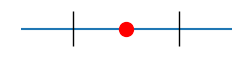

In [137]:
decision(lowerCI=lc,upperCI=uc,x=d_estimated)

> The result is statistically significant.  

> **Sign test:**

In [138]:
df['CTR control']=df['control clicks']/df['control pageviews']
df['CTR experiment']=df['experiment clicks']/df['experiment pageviews']
mkdtable(df)

|   control clicks |   control pageviews |   experiment clicks |   experiment pageviews |   CTR control |   CTR experiment |
|-----------------:|--------------------:|--------------------:|-----------------------:|--------------:|-----------------:|
|               51 |                1292 |                 115 |                   1305 |     0.0394737 |        0.0881226 |
|               39 |                 853 |                  73 |                    835 |     0.045721  |        0.0874251 |
|               64 |                1129 |                  91 |                   1133 |     0.0566873 |        0.0803177 |
|               43 |                 873 |                  60 |                    871 |     0.0492554 |        0.0688863 |
|               55 |                1197 |                  78 |                   1134 |     0.0459482 |        0.0687831 |
|               44 |                1023 |                  72 |                   1015 |     0.0430108 |        0.070936  |


> Day with higer CTR in experiment compared with control(positive change): 7/7  
> 
> If no difference: 50% chance of positive change on each day(like flipping a fair coin). Here, we just have 7 days, which cannot make a normal distribution assumption. Here, we can use an [online calculator](https://www.graphpad.com/quickcalcs/binomial1.cfm) to get the probability. The two-tail P value is 0.0156. This is the probability of observing a result at lease this extreme by chance. 0.0156<0.05, which means the sign test agrees with the hypothesis test, that this result was unlikely to come about by chance.
>
> Recommandation: Launch

> <span style="background-color: #90ccc3">Experiement 2:</span>  
> 
> Metric: 
> - CTR  
>
> Some data we have:
> - $d_{min}$=0.01  ;  $\alpha$=0.05  ;  $\beta$=0.2  
> - Empirical SE: 0.0062 with 5000 pageviews in each group.  
> - Control pageviews: 27948 ;  Control CTR: 0.1016  
> - Experiment pageviews: 28052;  Experiment CTR: 0.1131   

> **Sanity Check**

In [139]:
# set up data
N_cont_pageview=27948
N_exp_pageview=28052
CTR_control=0.1016
CTR_experiment=0.1131
d_min=0.01
alpha=0.05
SE_empirical=0.0062

Estimated difference=0.0115
Standard Error=0.0026
Margin of Error=0.0051
Confidence Interval=0.0064 to 0.0166


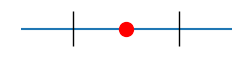

In [140]:
d_estimated=CTR_experiment-CTR_control
SE=0.0062/math.sqrt(1/5000+1/5000)*math.sqrt(1/N_cont_pageview+1/N_exp_pageview)
print(f'Estimated difference={d_estimated:.4f}')
print(f'Standard Error={SE:.4f}')
m=SE*1.96
print(f'Margin of Error={m:.4f}')
lc=d_estimated-m
uc=d_estimated+m
print(f'Confidence Interval={lc:.4f} to {uc:.4f}')
decision(lowerCI=lc,upperCI=uc,x=d_estimated)

> So, the result is statistically significant.

> **Sign test**   
> <img src="image/17.png" width="800">    
>   
> Days where CTR is higher in experiment compared with control: 9/14. From the online calculator, the two-tail P value is 0.4240, which is > 0.05. The result of sign test shows it is not statistically significant.

What do you do when the sign test and the hypothesis test don't agree?  
- consider Simpson's Paradox: there's a bunch of different subgroups in your data like user populations. And within each subgroup, the results are stable but when you aggregate them all together, it's the mix of subgroups that actually drives your result.  
- Simpson's Paradox: a real example about graduate admissions at Berkeley. 
    <img src="image/18.png" width="600">
   - In aggregate, if you looked at the number of people who are accepted divided by the number that applied, the rate of women being accepted (46%) was statistically significantly lower than men being accepted (52%), which seemed bad. But when you looked at it by department, there were actually departments where women were accepted at a higher rate than men. So how can that be? The answer turned out to be that you had to look at it by department, because the acceptance rates by department were variable. And what was happening is that more women were applying to the smaller departments that had a very low acceptance rate. So when you aggregated the numbers, ignoring department, you saw women accepted at a lower rate. But if you looked at each department individually, the rates were very comparable between men and women. 
   - In experiment, this happening on our experiment because you have these subgroups like people who use it more on weekdays or people use it more on weekends. And you may find that, for example, new users are correlated with weekend use and experienced users who react differently are correlated with weekday use. And so what sometimes you find in these cases is that what drives the results of your experiment are how many people from each group you get. Within each group, their behavior is stable, you can get a statistically significant result or an insignificant result. But when you add them all together, all the changes in your traffic mix are driving the results. 

#### **Multiple Metrics**  

When you run evaluations of multiple metrics at the same time, the more things you test, the more likely you are to see significant differences just by chance. So if you're testing 20 metrics, and you have a 95% confidence level. You would expect to see one case at least that time where you got a result that says it's significant but it's only concurring by chance. So this is a problem, but you're not sunk because it shouldn't be repeatable. That is if you did the same experiment on another day or you divide or just slices or you did some bootstrap analysis, you wouldn't see the same metric showing up as significant differences every time, it should occur randomly. There's another technique for this called [multiple comparisons](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) that adjusts your significance level, so that it accounts for how many metrics or how many different tests you're doing. One thing a lot of people like to do an experiment frameworks is do automatic detection of differences. So if you're doing exploratory data analysis you can reanalyze your data and make sure the same metric isn't popping up every time and see if the differences are repeatable. But if you want to set up say automatic alerting that tells you, one of my metrics was significantly different on this experiment. 



> Experiment:  
> - Prompt students to contact coach more frequently.  
> 
> Metrics:  
> - Probability that student signs up for coaching  
> - How early students sign up for coaching  
> - Average price paid per student  
>   
> Assume $\alpha$=0.05, for 3 metrics, the chance of at least 1 false positive:  
> - P(FP >= 1)= 1- P( FP = 0 ) = 1- 0.95 * 0.95 * 0.95=0.143 (assuming independent)

**Problem: Probability of any false positive increases as you increase number of metrics.**   
Solution: Use higher confidence level for each metric.  
- Method 1: assume independence:  
&emsp;&emsp;
  - $\alpha_{overall}=1-(1-\alpha_{individual})^n$   
  - This assumption allows us to apply the Bonferroni correction.  
&emsp;&emsp;
- Method 2: [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction)  
&emsp;&emsp;
  - The Bonferroni correction is a method used to control the familywise error rate (FWER) in hypothesis testing when conducting <span style="background-color: #edd2c4">multiple statistical comparisons simultaneously</span>. In the context of A/B testing, you might consider using the Bonferroni correction when you are running multiple comparisons, such as testing multiple variants or looking at several different metrics simultaneously. <span style="background-color: #edd2c4">The goal is to reduce the likelihood of making Type I errors (false positives) when conducting multiple hypothesis tests.</span>  
  - FWER represents the probability of making at least one Type I error across all these tests. This is the overarching error rate that we want to control when conducting multiple hypothesis tests simultaneously.
  - How Bonferroni correction works:  
    - $\alpha_{individual}=\frac{\alpha_{overall}}{N}$. N stands for the number of pairwise comparisons. 
    - $\alpha_{individual}$ is also known as Bonferroni-corrected significance level. This is the significance level we used in each comparison group.  
    - Perform individual hypothesis tests, compare the p-value obtained with $\alpha_{individual}$.
&emsp;&emsp;
  - Advantage of this method:  
    - Simple
    - no assumption
    - conservative: guaranteed to give $\alpha_{overall}$ at least as small as specified.  
&emsp;&emsp;
- Method 3: Control FDR  
&emsp;&emsp;
  - Control False Discovery Rate ( FDR = $E[\frac{ \text{\# false positive} }{\text{\# rejections}}]$ ): suppose you have 200 metrics, cap FDR at 0.05. This means you're okay with 5 false positives and 95 true positives in every experiment.  
  - Compared to Bonferroni correction, this method is less conservative. It is always more suitable when conducting a large number of hypothesis tests when controlling FWER is not neccessary.   

**When we settle on a bunch of metrics, how to make recommendations?**  

-  There are multiple comparisons or things along lines when you have multiple metrics. We hope that related metrics are all going to move in the same direction. <span style="font-size: smaller;"><span style="color: grey">For example, if you're measuring both click-through rate and click-through probability, hopefully they'll move in the same direction.</span></span> Another thing might happen when you have a composite metric is that multiple metrics can be unruly.<span style="font-size: smaller;"><span style="color: grey"> For example, RPM which is revenue per thousand queries is composed of both click through rate, as well as cost per clicks and so if you see. RPM of them one direction. Hopefully you can look at click through rate in cost per click to understand why it moved in that direction. Let's say you've decided that reading time on the page or stay time is a good signal. People like your page. But clicks are also a good signal. And so then you might see that when you make a UI change to the page people spend less time reading, but more time clicking. And then you really have to understand how people are reacting to the change because you can't quantitatively evaluate which one is better.</span></span> That's why sometimes people want to single overall evaluation criteria, so they can make the decision based on that. The main question when you try and come up with an OEC(overall evaluation criteria), is how do you find a good one? You really need to understand what your company is doing and what the problems are in order to try and come up with balancing. <span style="font-size: smaller;"><span style="color: grey">For example, balance state time and clicks. Is it seventy percent and thirty percent. Is it twenty five and seventy-five. Who knows or maybe. Quite frankly. Clicks is a bad measure for user experience.</span></span> An OEC doesn't absolve you of understanding why metrics are moving in these different directions. What it can be helpful with this balancing long term investment <span style="font-size: smaller;"><span style="color: grey">(like return visits to the site)</span></span> with short term day to day metrics <span style="font-size: smaller;"><span style="color: grey">(like increased clicks)</span></span>.  

**How do you come up with one?**

- Typically, there's a lot of validation in the process, but it usually begins with some form of business analysis. For instance, our company as a whole may aim for a 25% increase in revenue along with a 75% boost in site usage. Typically, we start from this point. Once we have a few candidates, we want to conduct a whole bunch of different experimentsto validate their impact and whether they steer us in the right direction. The challenge is to avoid overly planning based on the company's expectations for these experiments, which might obscure unexpected changes. At Google, we took a somewhat different approach. We gathered all the decision makers who had made launch decisions about hundreds of experiments. We presented them with experiment results without disclosing the specific test or the actual launch decision. We asked them to re-evaluate whether they would launch the changes based solely on the experiment results. . From this, we re-calibrated the weights for an OEC. We came up with an OEC that way, but whenever we tried using it to make a launch decision, everyone would look at the OEC to see what were the individual metrics that actually changed. So we never actually ended up using the OEC to actually make a decision. Now what the sort of tells us is that having an OEC doesn't have to be a formal number. It's really just trying to encapsulate what your company cares about. And how much you're going to be balancing.  


**Once we've identified metrics with significant changes, what's the next step?**  
- We need to determine what our results do and don't tell us. Statistically significant results indicate an impact on the user experience, but we must understand the nature of the change and decide if we should proceed with the launch. What if we have statistically significant changes in some metrics but not in others? Again, understanding the change is crucial. Intuition and experience from previous experiments can help. For instance, minor changes in one metric but no change in others might be acceptable, but for significant changes, it could indicate a problem.  
- The same principle applies to different user segments or slices. If a change has a positive impact on one slice but not on another, we must investigate why. It could be related to user preferences, prior observations in similar experiments, or even a technical issue. <span style="font-size: smaller;"><span style="color: grey">Is it a question about having different users, and how much they like or don't like the change? Have you seen that effect in other experiments? Do you have a bug? These are all possibilities when you have changes in one slice versus another. Let me give you an example. Bolding, right, we like to basically bold certain words in order to give them emphasis. Now, bolding in like English or German, or those types of alphabets, works really well for providing emphasis. But if you try and bold in Japanese, or Korean, or Chinese, a bolded character is actually really hard to read. And it actually makes it harder for a user to read the word than if it was not bolded. And so in that situation, you may actually want to want something different for that slice. Maybe use a different color as opposed to doing a bold. And then, bottom line, how do you decide whether to launch your change or not?</span></span> Ultimately, deciding whether to launch a change requires asking several questions. Are the results both statistically and practically significant? Do we understand the impact on the user experience? Is it worth implementing the change? The key is to provide a recommendation based on judgment, not just the technical aspects <span style="font-size: smaller;"><span style="color: grey">(designing the experiment and running it and sizing it properly, and having all of the metric chosen correctly)</span></span> of the experiment. What matters is whether the recommendation to launch or not was the right one.

**Is it ever advisable to gradually increase the exposure of your experiment?** <span style="font-size: smaller;"><span style="color: grey">For instance, you might begin by diverting only 1% of your traffic to the experiment group and then incrementally raise this proportion until the feature is fully launched.</span></span> 

- it's a prudent practice to implement a ramp-up when preparing to launch a change. This approach is consistently applied to all our launches at Google. Additionally, we remove all filters during this phase. Suppose you initially tested your change only on English-speaking users. In that case, during the ramp-up, it's essential to extend the testing to all users. This broader approach helps us identify any unintended impacts on unaffected users that may not have been part of the original experiment. However, there's an interesting challenge to consider during the ramp-up: the effects may flatten out as the change is gradually introduced. 

**What about cases where the initial effect was statistically significant? Isn't the point of statistical significance to ensure repeatability of results?** 

- Several straightforward reasons can explain why effects may not be repeatable. Seasonality effects, <span style="font-size: smaller;"><span style="color: grey">such as those related to student behavior during summer vacation or holidays like Black Friday and Cyber Monday, can significantly alter online behavior.</span></span> To account for these seasonal or event-driven impacts, we use a method called a "holdback." This involves launching the change to everyone except for a small group of users who don't receive the change, allowing us to compare their behavior to the control group. Over time, this analysis helps us determine if the results are indeed repeatable and capture seasonal or event-driven effects.

**Are there other factors that can cause this vanishing launch effect?**  
- Indeed, we've touched on this topic in previous lessons. Factors like a novelty effect or change aversion can influence user behavior. As users discover, adopt, or modify their adoption of your change, their behavior and the measured effects can shift. Cohort analysis can be especially useful in such cases. Additionally, in situations involving advertisers with budgets, improper budget controls can lead to changing effects as you ramp up.

**How can I detect these issues during the experiment rather than discovering them after the launch has occurred and something has gone awry?** 
- To address these complexities, you'll need to delve into more advanced analyses and experiment designs. As discussed in lesson four, employing pre- and post-periods can be beneficial. If you're concerned about learning effects, combining pre- and post-periods with a cohort analysis can help you understand how users adapt to the change over time.



## Conclusion

1. **Check.** Double check, triple check that your experiment was set up properly. Look at your end variance. Check that your experiment metrics are actually looking sane. you have to check that before you try and do anything else. 

2. **Significant.** Remember you aren't just looking for statistical significance. You're really making a business decision. So what if you have an experiment that statistically significantly improves the experience for 30% of users but it's neutral for everyone else. Do you necessarily want to launch it as it is or do you want to try to make it better. And what if you're in a situation where it improves things for 70% but makes it worse for 30%. So you actually need to make a decision about whether you want to launch the feature as it is, or if you want to try to fine tune it first. 

3. **Overall business analysis.** For example, what's the engineering cost of maintaining the change? Are there customer support or sales issues? Overall what's the opportunity cost if you actually choose to launch the change relative to the rewards you're going to get from the change or potentially not launching the change? This is all about the judgment call with regards to the user experience and the business. And ultimately that's what your commission has to be based on. 

If you haven't actually tested your change on all traffic, even if it only impacts a small slice, now's a good time to test for that incidental impact. If this is the first experiment you run, especially if it's a really big or important feature, you might want to actually try running a couple of different experiments. Analyzing the results and then seeing how you feel about the results of your first experiment before you decide to launch it. 